<a href="https://colab.research.google.com/github/nahumsa/VAE-RBM-Pretraining/blob/master/Pretraining_dSprites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Beta-Variational-Autoencoder-Using-Keras-data-Dsprites" data-toc-modified-id="Beta-Variational-Autoencoder-Using-Keras-data-Dsprites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Beta Variational Autoencoder Using Keras data Dsprites</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Building-the-Beta-VAE" data-toc-modified-id="Building-the-Beta-VAE-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Building the Beta-VAE</a></span><ul class="toc-item"><li><span><a href="#Using-RBM-Initialization" data-toc-modified-id="Using-RBM-Initialization-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Using RBM Initialization</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Reconstruction" data-toc-modified-id="Reconstruction-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Reconstruction</a></span></li><li><span><a href="#Traversals" data-toc-modified-id="Traversals-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Traversals</a></span></li></ul></li></ul></li></ul></div>

# Beta Variational Autoencoder Using Keras data Dsprites

The code is based on the book [Generative Deep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/) and on this [repository](https://github.com/lane203j/deep-autoencoder-with-RBM-pretraining). But here we apply the RBM pretraining to the Beta-Variational autoencoder.

In [0]:
!git clone https://github.com/nahumsa/VAE-RBM-Pretraining

Cloning into 'VAE-RBM-Pretraining'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 35 (delta 11), reused 35 (delta 11), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [2]:
% cd VAE-RBM-Pretraining/

/content/VAE-RBM-Pretraining


## Data

The data is taken from [Dsprites dataset](https://github.com/deepmind/dsprites-dataset). 

For loading the dataset we used this [notebook](https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb).

The datafiles are on the input folder.


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
from keras.utils import np_utils
import seaborn as sns
import os

# Change figure aesthetics
%matplotlib inline
sns.set_context('paper', font_scale=1.2, rc={'lines.linewidth': 1.5})

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Using TensorFlow backend.


In [0]:
path = os.getcwd()
dataset_zip = np.load(path+'/Data/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                     ,encoding='bytes', allow_pickle=True)

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]


print('Metadata: \n', metadata)

Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7fe1cba54390>)
Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22

In [0]:
# Define number of values per latents and functions to convert to indices
import copy
latents_sizes = metadata[b'latents_sizes']
latents_sizes_x_y = copy.copy(latents_sizes)
latents_sizes_x_y[:-2] = [1]*len(latents_sizes_x_y[:-2])

In [0]:
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

In [0]:
latents_bases_x_y = np.concatenate((latents_sizes_x_y[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

In [0]:
def latent_to_index(latents):    
    return np.dot(latents, latents_bases).astype(int)

def latent_to_index_x_y(latents):    
    return np.dot(latents, latents_bases_x_y).astype(int)

def sample_latent_fix_shape(size=1,shape_index=0):
    """Sample the latent space fixing the 
    shape.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    shape_index(integer): Choose the shape that you want:
                          0: Square
                          1: Ellipse
                          2: Heart
                         (default=0)
    
    """
    
    samples = np.zeros((size, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)
    
    samples[:,1] = shape_index
    return samples

def sample_latent_changing_x_y(size=1):
    """Sample the latent space changing only the position.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    
    """
    
    
    samples = np.zeros((size, latents_sizes.size))
    
    
    for lat_i, lat_size in enumerate(latents_sizes):                
        if lat_i in range(len(latents_sizes)-2):
            samples[:, lat_i] = 0
        else:          
            samples[:, lat_i] = np.random.randint(lat_size, size=size)        
    
    return samples

def sample_latent(size=1):
    """Sample the latent space.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    
    """
    
    samples = np.zeros((size, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

In [0]:
# Sample latents randomly
n_samples_train = 30000
latents_sampled_train = sample_latent(size=n_samples_train)

# Select images
indices_sampled_train = latent_to_index_x_y(latents_sampled_train)
imgs_sampled_train = imgs[indices_sampled_train]

x_train = imgs[indices_sampled_train]
x_train = x_train.reshape((n_samples_train,x_train.shape[1]*x_train.shape[2])).T

In [0]:
# Sample latents randomly 
n_samples_test = 5000
latents_sampled = sample_latent(size=n_samples_test)

# Select images
indices_sampled = latent_to_index_x_y(latents_sampled)
imgs_sampled = imgs[indices_sampled]

x_test = imgs[indices_sampled]
x_test = x_test.reshape((n_samples_test,x_test.shape[1]*x_test.shape[2])).T

In [0]:
print('Analysing the shapes:\n'+ 
      f' X train shape: {x_train.shape} \n X test shape: {x_test.shape}')

Analysing the shapes:
 X train shape: (4096, 30000) 
 X test shape: (4096, 5000)


## Building the Beta-VAE

### Using RBM Initialization

In [0]:
# run params
SECTION = 'bvae_RBM'
RUN_ID = '0001'
DATA_NAME = 'DSPRITES'
RUN_FOLDER = f'run/{SECTION}/'
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from keras.models import Model
from Models.VAE import VariationalAutoencoder

#Parameters
layers = [x_train.shape[0], 1000, 512, 256, 2]
epochs_pretraining = 5

#Defining the Beta-VAE
bvae = VariationalAutoencoder(layer_dims = layers)
bvae.pretrain(x_train.T ,epochs = epochs_pretraining, num_samples = 1000)

bvae.unroll()

Pretraining 

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1

Training RBM layer 1, size: 4096
Training RBM layer 2, size: 1000
Training RBM layer 3, size: 512












In [0]:
bvae.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
encoder_dense_0 (Dense)         (None, 1000)         4097000     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_dense_1 (Dense)         (None, 512)          512512      encoder_dense_0[0][0]            
__________________________________________________________________________________________________
encoder_dense_2 (Dense)         (None, 256)          131328      encoder_dense_1[0][0]            
____________________________________________________________________________________________

In [0]:
#Compile Parameters (These parameters depend on a fine tuning) 
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 5
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [0]:
# Training Parameters

BATCH_SIZE = 126

EPOCHS = 20

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 0

In [0]:
bvae.train(     
    x_train.T
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
          )

## Analysis

### Reconstruction

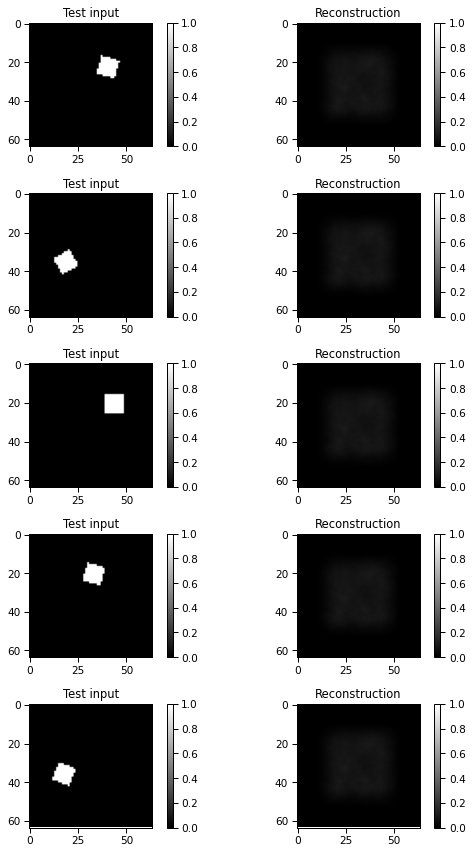

In [0]:
n_to_show = 5
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test.T[example_idx]

z_points = bvae.encoder.predict(example_images)

reconst_images = bvae.decoder.predict(z_points)

plt.figure(figsize=(8, 12))
for i in range(n_to_show):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(example_images[i].reshape(64, 64), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(reconst_images[i].reshape(64, 64), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

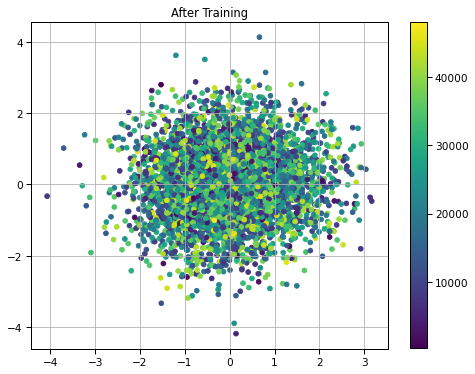

In [0]:
z_mu = bvae.encoder.predict(x_test.T)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=indices_sampled)
plt.colorbar()
plt.title('After Training')
plt.grid()

### Traversals

We choose a random point on the latent space that corresponds to an image.

In [0]:
example_images.T.shape

In [0]:
n_to_show = 1
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test.T[example_idx]
z_points = bvae.encoder.predict(example_images)
reconst_images = bvae.decoder.predict(z_points)

In [0]:
def traverse(pos,traverse_value,latent_vector):
    """Make the traverse on pos at the latent
    vector
    
    Parameters
    ------------------------------------------
    pos(int): Position at the latent vector that 
              you want to traverse.
    latent_vector(list): Latent vector.
    
    """
    latent_vector[0][pos] = traverse_value
    
    return latent_vector      

In [0]:
from copy import copy

#number of imgs
n_traverse = 10

#minimum value of traversal
min_t = -3

#maximum value of traversal
max_t = 3

plt.imshow(reconst_images.reshape(64, 64), cmap='gray')
plt.title("Original \n Latent Vector: {}".format(z_points[0]))

for j in range(bvae.latent_dim):
    
    fig = plt.figure(figsize=(18,5))
    fig.subplots_adjust(hspace=0.4,wspace=0.1)    
    
    for i,val in enumerate(np.linspace(min_t,max_t,n_traverse)):
        #Use copy in order to not overwrite z_points
        Latent_T = traverse(j,val,copy(z_points)) 
        reconst_image = bvae.decoder.predict(Latent_T)
        ax = fig.add_subplot(1, n_traverse, i+1)
        ax.imshow(reconst_image.reshape(64, 64), cmap='gray')
        ax.axis('off')
        ax.set_title("{:.3f}".format(val))
    fig.suptitle('Changing Latent Position {}'.format(j),x=0.5,y=0.75, fontsize=16)
    
    plt.show()